<a id="tercero"></a>
## 3. Autoencoders (AEs) en MNIST
Como se ha discutido en clases, las RBM’s y posteriormente los AE’s (redes no supervisadas) fueron un componente crucial en el desarrollo de los modelos que entre 2006 y 2010 vigorizaron el área de las redes neuronales artificiales con logros notables de desempeño en diferentes tareas de aprendizaje automático. En esta sección aprenderemos a utilizar el más sencillo de estos modelos: un autoencoder o AE. Consideraremos tres aplicaciones clásicas: reducción de dimensionalidad, denoising y pre-entrenamiento. Con este objetivo en mente, utilizaremos un dataset denominado MNIST. Se trata de una colección de 70000 imágenes de 28 $\times$ 28 pixeles correspondientes a dígitos manuscritos (números entre 0 y 9). En su versión tradicional, la colección se encuentra separada en dos subconjuntos: uno de entrenamiento de 60000 imágenes y otro de test de 10000 imágenes. La tarea consiste en construir un programa para que aprenda a identificar correctamente el dı́gito representado en la imagen


> a) Escriba una función que cargue los datos desde el repositorio de keras, normalice las imágenes de modo que los pixeles queden en [0, 1], transforme las imágenes en vectores ($\in {\rm I\!R}^{784}$) y devuelva tres subconjuntos disjuntos: uno de entrenamiento, uno de validación y uno de pruebas. Construya el conjunto de validación utilizando los últimos $nval = 5000$ casos del conjunto del entrenamiento. El conjunto de entrenamiento consistirá en las primeras $60000 - nval$ imágenes.
```python
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255. #and x_test
#Define here your validation set
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
```



In [1]:
from keras.datasets import mnist
import numpy as np
from keras.utils import np_utils, plot_model

(x_training, y_training), (x_test, y_test) = mnist.load_data()

print("Las dimensiones del dataframe de entrenamiento son:",x_training.shape)
print("Las dimensiones del dataframe de entrenamiento son:",y_training.shape)
print("Las dimensiones del dataframe de pruebas son:",x_test.shape)
print("Las dimensiones del dataframe de pruebas son:",y_test.shape)

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Las dimensiones del dataframe de entrenamiento son: (60000, 28, 28)
Las dimensiones del dataframe de entrenamiento son: (60000,)
Las dimensiones del dataframe de pruebas son: (10000, 28, 28)
Las dimensiones del dataframe de pruebas son: (10000,)


In [2]:
x_training = x_training.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train=x_training[:50000]
y_train=y_training[:50000]
x_val=x_training[50000:]
y_val=y_training[50000:]

print("Las dimensiones del dataframe de entrenamiento son:",x_train.shape)
print("Las dimensiones del dataframe de entrenamiento son:",y_train.shape)
print("Las dimensiones del dataframe de validación son:",x_val.shape)
print("Las dimensiones del dataframe de validación son:",y_val.shape)

Y_train = np_utils.to_categorical(y_train, 10)
Y_val = np_utils.to_categorical(y_val, 10)
Y_test = np_utils.to_categorical(y_test, 10)

Las dimensiones del dataframe de entrenamiento son: (50000, 28, 28)
Las dimensiones del dataframe de entrenamiento son: (50000,)
Las dimensiones del dataframe de validación son: (10000, 28, 28)
Las dimensiones del dataframe de validación son: (10000,)


### 3.1 Reducción de dimensionalidad
Para esta primera sección se trabajará con un autoencoder tradicional (*feed forward*) en donde las capas de este son densas. Para esto se re estructuraran los datos de entradas en forma de vector, es decir la matriz de 28 $\times$ 28 pasa a ser un vector de 784 componentes.

```python
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
```

Una de las aplicaciones tı́picas de un AE es reducción de dimensionalidad, es decir, implementar una transformación $\phi:{\rm I\!R}^d \leftarrow {\rm I\!R}^{d'}$ de objetos representados originalmente por $d$ atributos en una nueva representación de $d'$ atributos, de modo tal que se preserve lo mejor posible la “información” original. Obtener tal representación es útil desde un punto de vista computacional (compresión) y estadı́stico (permite construir modelos con un menor número de parámetros libres). Un AE es una técnica de reducción de dimensionalidad no supervisada porque no hace uso de información acerca de las clases a las que pertenecen los datos de entrenamiento
> a) Entrene un AE básico (1 capa escondida) para generar una representación de MNIST en $d'$= 2, 8, 32, 64 dimensiones. Justifique la elección de la función de pérdida a utilizar y del criterio de entrenamiento en general. Determine el porcentaje de compresión obtenido y el error de reconstrucción en cada caso. ¿Mejora el resultado si elegimos una función de activación **ReLU** para el Encoder? ¿Podrı́a utilizarse esta activación en el Decoder?
```python
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
input_img = Input(shape=(784,))
encoded = Dense(32, activation='sigmoid')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input=input_img, output=decoded)
encoder = Model(input=input_img, output=encoded)
encoded_input = Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
##
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(x_train,x_train,epochs=50,batch_size=32,validation_data=(x_val,x_val))
autoencoder.save('basic_autoencoder_768x32.h5')
#save other stuffs
```



In [3]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_val = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print("Las dimensiones del dataframe de entrenamiento son:",x_train.shape)
print("Las dimensiones del dataframe de entrenamiento son:",y_train.shape)
print("Las dimensiones del dataframe de validación son:",x_val.shape)
print("Las dimensiones del dataframe de validación son:",y_val.shape)
print("Las dimensiones del dataframe de pruebas son:",x_val.shape)
print("Las dimensiones del dataframe de pruebas son:",y_val.shape)

Las dimensiones del dataframe de entrenamiento son: (50000, 784)
Las dimensiones del dataframe de entrenamiento son: (50000,)
Las dimensiones del dataframe de validación son: (10000, 784)
Las dimensiones del dataframe de validación son: (10000,)
Las dimensiones del dataframe de pruebas son: (10000, 784)
Las dimensiones del dataframe de pruebas son: (10000,)


In [4]:
y_train = np_utils.to_categorical(y_train, 10)
y_val = np_utils.to_categorical(y_val, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [5]:
input_img = Input(shape=(784,))
encoded = Dense(32, activation='sigmoid')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(inputs=input_img, output=decoded)
encoder = Model(inputs=input_img, output=encoded)
encoded_input = Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(inputs=encoded_input, output=decoder_layer(encoded_input))


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


In [6]:
#plot_model(autoencoder, to_file='model_auto.png', show_shapes=True)

#error de graphviz y pydot

In [7]:
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
hist = autoencoder.fit(x_train,x_train,epochs=50,batch_size=32,shuffle=True,validation_data=(x_val, x_val))

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 164us/step - loss: 0.3082 - val_loss: 0.2673
Epoch 2/50
50000/50000 [==============================] - 7s 139us/step - loss: 0.2671 - val_loss: 0.2639
Epoch 3/50
50000/50000 [==============================] - 7s 138us/step - loss: 0.2653 - val_loss: 0.2629
Epoch 4/50
50000/50000 [==============================] - 7s 139us/step - loss: 0.2646 - val_loss: 0.2624
Epoch 5/50
50000/50000 [==============================] - 7s 138us/step - loss: 0.2642 - val_loss: 0.2621
Epoch 6/50
50000/50000 [==============================] - 7s 139us/step - loss: 0.2640 - val_loss: 0.2619
Epoch 7/50
50000/50000 [==============================] - 7s 139us/step - loss: 0.2638 - val_loss: 0.2618
Epoch 8/50
50000/50000 [==============================] - 7s 139us/step - loss: 0.2637 - val_loss: 0.2617
Epoch 9/50
50000/50000 [==============================] - 7s 139us/step - loss: 0.2636 - val_loss: 0.2

In [8]:
autoencoder.save('basic_autoencoder_768x32.h5')

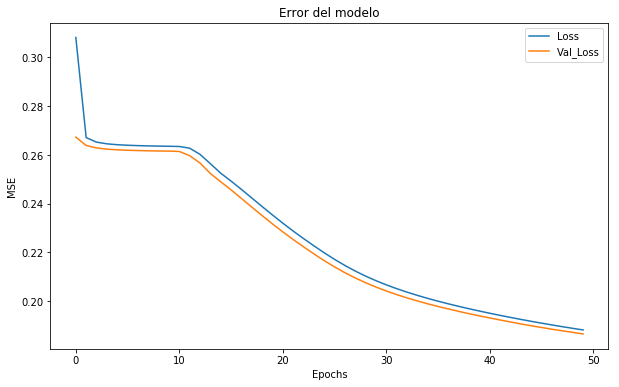

In [10]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10, 6))
plt.plot(hist.history['loss'],label="Loss")
plt.plot(hist.history['val_loss'],label="Val_Loss")
plt.title("Error del modelo")
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()


> b) Compare visualmente la reconstrucción que logra hacer el autoencoder desde la representación en ${\rm I\!R}^{d'}$ para algunas imágenes del conjunto de pruebas. Determine si la percepción visual se corresponde con el error de reconstrucción observada. Comente.
```python
from keras.models import load_model
autoencoder = load_model('basic_autoencoder_768x32.h5')
#load other stuff ...
encoded_test = encoder.predict(x_test)
decoded_test = decoder.predict(encoded_test)
import matplotlib
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
```



In [11]:
from keras.models import load_model
autoencoder = load_model('./basic_autoencoder_768x32.h5')

3

In [12]:
#Reconstruir desde autoencoder ...la primera capa es el encoder y la ultima la decoder
input_img = autoencoder.input
encoder_layer = autoencoder.layers[-2]
encoder = Model(inputs=input_img, outputs=encoder_layer(input_img))
decoded_shape = Input(shape=(32,))   
decoder_layer = autoencoder.layers[-1] 
decoder = Model(inputs=decoded_shape, outputs=decoder_layer(decoded_shape))

encoded_test = encoder.predict(x_test)
decoded_test = decoder.predict(encoded_test)

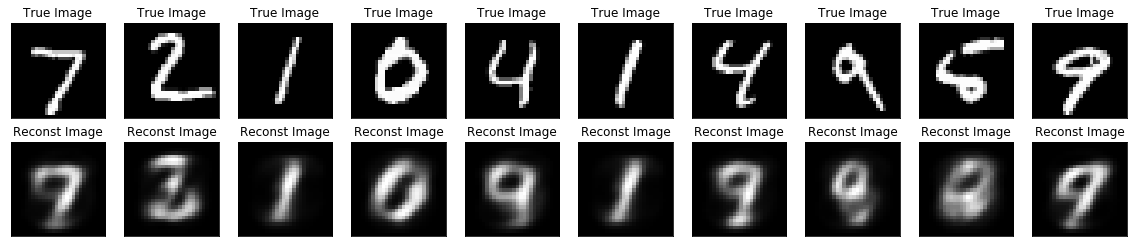

In [20]:
n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("True Image")
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("Reconst Image")
    
plt.show()

> c) Para verificar la calidad de la representación obtenida, implemente el clasificador denominado $kNN$ (k-nearest neighbor): dada una imagen $x$, el clasificador busca las k = 10 imágenes de entrenamiento más similares (de acuerdo a una distancia, e.g. euclidiana) y predice como clase, la etiqueta más popular entre las imágenes cercanas. Mida el error de pruebas obtenido construyendo este clasificador sobre la data reducida a través del autocnder comparando con la representación reducida obtenida vía PCA (una técnica clásica de reducción de dimensionalidad) utilizando el mismo número de dimensiones $d'$= 2, 4, 8, 16, 32. Considere tanto el error de reconstrucción como el desempeño en clasificación , además de comparar los tiempos medios de predicción en ambos escenarios.
```python
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
pca = PCA(n_components=d)
#PCA
pca.fit(x_train)
pca_train = pca.transform(x_train)
pca_test = pca.transform(x_test)
#AUTOENCODER
encoded_train = encoder.predict(x_train)
encoded_test = encoder.predict(x_test)
#CLASIFICATION
clf = KNeighborsClassifier(10)
clf.fit(pca_train, y_train)
print 'Classification Accuracy PCA %.2f' % clf.score(pca_test,y_test)
clf = KNeighborsClassifier(10)
clf.fit(encoded_train, y_train)
print 'Classification Accuracy %.2f' % clf.score(encoded_test,y_test)
```



> d) Modifique el autoencoder básico construido en (a) para implementar un deep autoencoder (*deep AE*), es decir, un autoencoder con al menos dos capas ocultas. Demuestre experimentalmente que este autoencoder puede mejorar la compresión obtenida por PCA utilizando el mismo número de dimensiones $d'$ . Experimente con $d'$ =2, 4, 8, 16 y distintas profundidades (L = 2, 3, 4). Considere en esta comparación tanto el error de reconstrucción como el desempeño en clasificación (vı́a kNN) de cada representación. Comente.
```python
target_dim = 2 #try other and do a nice plot
input_img = Input(shape=(784,))
encoded1 = Dense(1000, activation='relu')(input_img)
encoded2 = Dense(500, activation='relu')(encoded1)
encoded3 = Dense(250, activation='relu')(encoded2)
encoded4 = Dense(target_dim, activation='relu')(encoded3)
decoded4 = Dense(250, activation='relu')(encoded4)
decoded3 = Dense(500, activation='relu')(encoded3)
decoded2 = Dense(1000, activation='relu')(decoded3)
decoded1 = Dense(784, activation='sigmoid')(decoded2)
autoencoder = Model(input=input_img, output=decoded1)
encoder = Model(input=input_img, output=encoded3)
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(x_train,x_train,epochs=40,batch_size=32,validation_data=(x_val,x_val))
autoencoder.save('my_autoencoder_768x1000x500x250x2.h5')
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
pca = PCA(n_components=target_dim)
pca.fit(x_train)
```




> e) Elija algunas de las representaciones aprendidas anteriormente y visualı́celas usando la herramienta *TSNE* disponible en la librerı́a *sklearn*. Compare cualitativamente el resultado con aquel obtenido usando PCA con el mismo número de componentes
```python
nplot=5000 #warning: mind your memory!
encoded_train = encoder.predict(x_train[:nplot])
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
encoded_train = model.fit_transform(encoded_train)
plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in xrange(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)
pca_train = pca.transform(x_train)
encoded_train = pca_train[:nplot]
... #plot PCA
```



> f) Modifique el autoencoder construido en (a) para trabajar directamente sobre las imágenes de MNIST, sin tratarlas como vectores de 784 atributos, sino como matrices de tamaño $1\times28\times28$. Es posible lograr este objetivo utilizando capas convolucionales para definir el Encoder y el Decoder, comente como sufre las transformaciones el patrón de entrada. Compare la calidad de la representación reducida obtenida por el nuevo autoencoder con aquella obtenida anteriormente utilizando el mismo número de dimensiones. Comente.
```python
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) #modify for th dim ordering
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
input_img = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()
```


### 3.2 Denoising
Como se ha discutido en clases, un denoising autoencoder (dAE) es esencialmente un autoencoder entrenado para reconstruir ejemplos parcialmente corruptos. Varios autores han demostrado que mediante esta modificación simple es posible obtener representaciones más robustas y significativas que aquellas obtenidas por un AE básico. En esta sección exploraremos la aplicación más “natural” o “directa” del método.

> a) Genere artificialmente una versión corrupta de las imágenes en MNIST utilizando el siguiente modelo de ruido (masking noise): si $x\in {\rm I\!R}^d$ es una de las imágenes originales, la versión ruidosa $\~{x}$ se obtiene como $\~{x} = x \odot \xi$ donde $\odot$ denota el producto de Hadamard (componente a componente) y $\xi \in {\rm I\!R}^d$ es un vector aleatorio binario con componentes *Ber(p)* independientes.
```python
from numpy.random import binomial
noise_level = 0.1
noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
noisy_x_train = x_train*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
noisy_x_val = x_val*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
noisy_x_test = x_test*noise_mask
```

> b) Entrene un autoencoder para reconstruir las imágenes corruptas generadas en el ı́tem anterior. Mida el error de reconstrucción y evalúe cualitativamente (visualización de la imagen corrupta y reconstruida) el resultado para un subconjunto representativo de imágenes. Experimente diferentes valores de *p* en el rango (0, 1).
```python
# DEFINE YOUR AUTOENCODER AS BEFORE
autoencoder.fit(noisy_x_train, x_train, epochs=40, batch_size=32, validation_data=(noisy_x_val, x_val))
```

> c) Utilice estas imágenes intencionalmente corruptas para entrenar un AE con fines de reducción de dimensionalidad. Durante el entrenamiento, proceda exactamente como en (b), pero su objetivo no será hacer *denoising* sino obtener una representación comprimida de alta calidad de las imágenes originales. Al final del entrenamiento, mida el error de reconstrucción como el desempeño en clasificación (vı́a kNN como en la sección anterior) de la representación obtenida. Comente.

> d) Diseñe otra manera de generar imágenes corruptas del dataset MNIST, por ejemplo algún tipo de ruido, sea creativo. Mida el error de reconstrucción y evalúe cualitativamente (visualización de la imagen corrupta y reconstruida) el resultado para un subconjunto representativo de imágenes